# Importing Library

In [1]:
import warnings
warnings.filterwarnings("ignore") # not display warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # 
sns.set()
# nltk = natural language tool kit
from nltk.corpus import stopwords # unimportant words
from sklearn.feature_extraction.text import TfidfVectorizer # words to vector
from nltk.stem.snowball import SnowballStemmer # action words to pronouns
from sklearn.preprocessing import StandardScaler # standardization (0, 1)
from sklearn.model_selection import train_test_split # divide data in 2 parts
from sklearn.metrics import confusion_matrix , accuracy_score , f1_score
from sklearn.decomposition import TruncatedSVD # Dimentionality Reduction
from tqdm import tqdm # display processing status
import re # regular experession 
# models / algorithms
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC , SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

# Data Preprocessing and Visualisation

In [2]:
Train = pd.read_csv("train.csv") # using CSV file

In [3]:
Train.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print(f"No of Question pair {Train.shape[0]}") # no. of rows

No of Question pair 404290


In [5]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
Train.is_duplicate.value_counts() # 0 = not duplicate; 1 = duplicate

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
#Train_on = 10000
#Train = Train.head(Train_on)
#Train.is_duplicate.value_counts()

In [8]:
# based on id diffren. the how many questions are unique
qid = pd.Series(Train.qid1.to_list() + Train.qid2.to_list()) 
unique_questions = len(np.unique(qid)) 
no_repeat_qid = np.sum( qid.value_counts() > 1) # repeated

print("Total no. of unique question :",unique_questions)
print("Total no. of question repeated:",no_repeat_qid)
print("Maximum time any question occurs :", np.max(qid.value_counts()))

Total no. of unique question : 537933
Total no. of question repeated: 111780
Maximum time any question occurs : 157


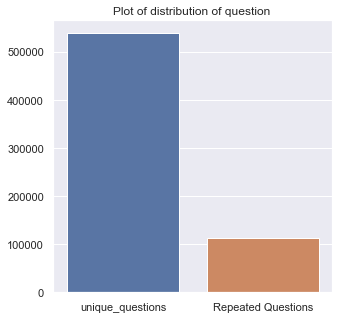

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_questions , no_repeat_qid ]

plt.figure(figsize = (5,5))
sns.barplot(x,y)
plt.title("Plot of distribution of question ")
plt.show()

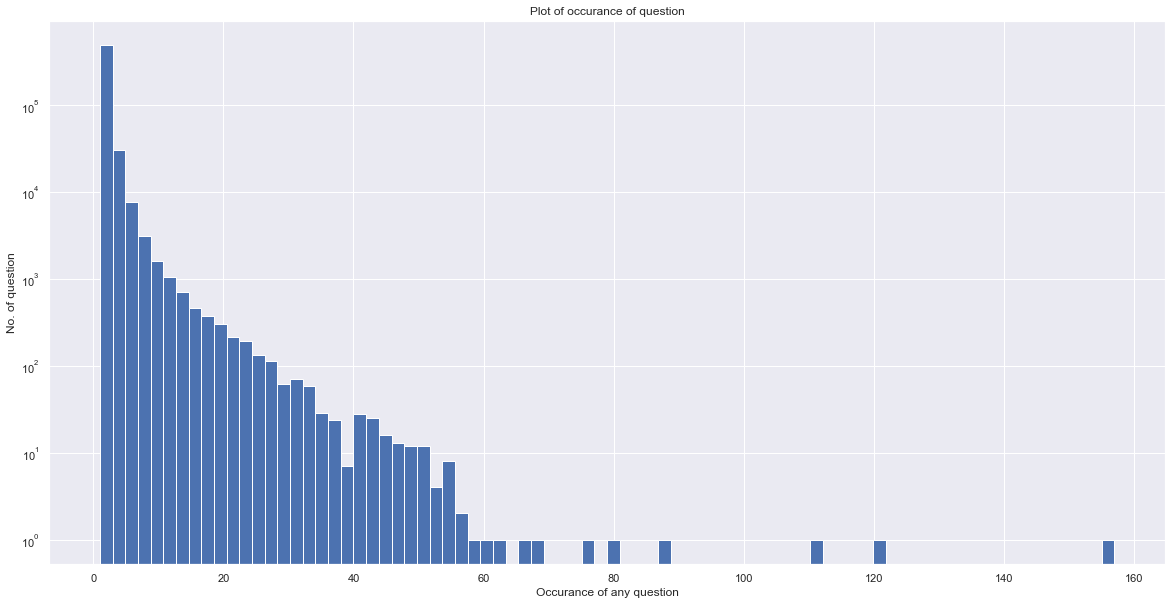

In [10]:
plt.figure(figsize= (20,10))
plt.hist(qid.value_counts(),bins =80) # how many times a question is occuring
plt.yscale('log', nonposy='clip')
plt.xlabel("Occurance of any question")
plt.ylabel("No. of question")
plt.title("Plot of occurance of question")
plt.show()

Hence from above graphs we can easily assume that majorly every question has single occurance and there is one question which occurs 157 times.

In [11]:
#series = 1D array
question1 = pd.Series(Train["question1"])
question2 = pd.Series(Train.question2)

# Natural Language Processing

In [12]:
# pre-defined in library
stop_words = set(stopwords.words("english"))
len(stop_words)

179

In [13]:
print(stop_words)

{'any', 'o', "it's", 'him', 'when', 'ain', 'then', 'her', 'shouldn', 'ourselves', 'now', 'on', 'haven', 'they', 'such', 'there', 'after', 'don', 'hasn', 'under', 'as', 'do', 'for', 'same', 'my', "couldn't", 'herself', 'off', 'being', 'll', "won't", 'of', 'can', "hadn't", 'needn', 'was', 'that', "that'll", 'have', "she's", 'through', 'until', 'where', 't', 'or', 'y', "isn't", "shouldn't", 'you', 's', "wasn't", 'with', 'were', 'mightn', 'above', 'these', "didn't", 'both', 'been', 'this', "you'll", 'he', 'up', 'against', 'did', 'yours', 'themselves', 'very', 'about', 'those', 'during', 'our', 'hers', 'down', "mightn't", "needn't", 'out', 'i', 'wouldn', 'not', "doesn't", "you're", 'to', 'its', 'we', 'which', 'me', 'a', 'but', 'having', 'm', 'here', 'myself', 'itself', 'if', 'so', 'his', 'while', "shan't", 'should', 'shan', 'how', 'in', 'some', 'too', 'yourselves', 'because', 've', 'isn', 'couldn', 'ma', 'what', "weren't", "mustn't", 'ours', 'further', "you'd", 'into', 'aren', 'doesn', 'why

In [14]:
preprocessed_q1 = []
preprocessed_q2 = []

def preprocess(x):
    x = str(x).lower() # convert to lower case
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    x = x.split() # string to list
    
    stemmer = SnowballStemmer(language= "english") 
    string = ""
    for word in x:
        if word not in stop_words and word.strip() != "":
            word = stemmer.stem(word) # convert every word to present tense
            string += word + " " # convert back to string
            
    return string.strip() # remove white space

for question in tqdm(question1):
    preprocessed_q1.append(preprocess(question))
    
for question in tqdm(question2):
    preprocessed_q2.append(preprocess(question))

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [00:35<00:00, 11258.97it/s]


In [15]:
preprocessed_q1[:4]

['step step guid invest share market india?',
 'stori kohinoor (koh-i-noor) diamond?',
 'increas speed internet connect use vpn?',
 'mental lonely? solv it?']

In [16]:
tfidf = TfidfVectorizer() 
q1_vec = tfidf.fit_transform(preprocessed_q1)
q2_vec = tfidf.fit_transform(preprocessed_q2)

In [17]:
print(q1_vec.shape) 
print(q2_vec.shape) 
#print(q1_vec[0])

(404290, 65863)
(404290, 60639)


# Dimentionality Reduction and Data Formatting

In [18]:
svd = TruncatedSVD(n_components = 200) # reduce dimension
q1_vec = svd.fit_transform(q1_vec)

In [19]:
q2_vec = svd.fit_transform(q2_vec)

In [20]:
len(q2_vec)

404290

In [21]:
Xtrain1 = pd.DataFrame(q1_vec)
Xtrain1["id"] = [i for i in range(len(q2_vec))]
Xtrain2 = pd.DataFrame(q2_vec)
Xtrain2["id"] = [i for i in range(len(q2_vec))]

Xtrain = Xtrain1.merge(Xtrain2 , on = "id" , how = "left") # join the vectors

In [22]:
print(Xtrain.shape)
Xtrain.head()

(404290, 401)


,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,0.046584,0.005741,0.044117,-0.033217,-0.022881,0.119593,0.005375,0.044345,-0.002952,-0.079463,...,-0.000634,-0.012572,-0.026025,-0.010176,-0.011136,0.007910,-0.014569,-0.005540,0.017556,-0.026540
1,0.002520,0.000595,0.000687,-0.001951,-0.001228,-0.000537,-0.001195,-0.000102,0.000336,-0.000448,...,0.046448,0.001229,0.027704,-0.005173,0.049155,0.037439,-0.009728,0.039097,0.002822,0.003016
2,0.027727,0.027320,0.020188,-0.004656,0.003830,-0.009205,0.015683,0.006733,0.008755,0.000667,...,0.157958,-0.021080,0.019835,0.110586,0.074283,-0.030465,-0.042270,-0.060709,-0.110993,-0.024997
3,0.009995,0.014316,0.008882,-0.010214,-0.000115,-0.002287,0.003632,0.001339,0.003757,0.003820,...,-0.009715,-0.004178,0.002053,-0.001774,-0.006049,-0.000302,0.005548,0.004893,-0.008396,0.006196
4,0.011000,0.011724,0.013365,-0.016062,-0.005997,-0.011066,0.000095,0.004834,-0.002699,-0.002082,...,-0.039910,0.003324,-0.001270,0.003712,0.019944,-0.020166,0.005663,-0.008450,0.007799,-0.028291


In [23]:
Scaler = StandardScaler()
Xtrain = Scaler.fit_transform(Xtrain)
#print(Xtrain)

In [24]:
Xtrain = pd.DataFrame(Xtrain)
Xtrain.head()
Ytrain = pd.Series(Train.is_duplicate)

In [25]:
X_train , X_test , Y_train , Y_test = train_test_split(Xtrain, Ytrain) # 75:25

In [26]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(303217, 401) (303217,)
(101073, 401) (101073,)


In [27]:
model_accuracy = []
model_fm = []

# Using Logistic Regression

In [28]:
model = LogisticRegression()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(Y_test , y_pred))
print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

Accuracy :  0.7063013861268588
Confusion Matrix : 
 [[57433  6243]
 [23442 13955]]
f-measure :  0.48459067627398206


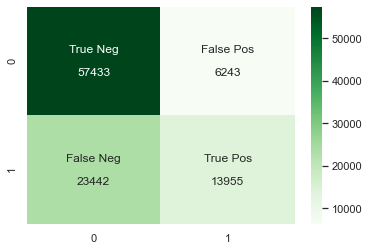

In [29]:
#plt.imshow(confusion_matrix(Y_test , y_pred))

cf_matrix = confusion_matrix(Y_test , y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.grid(b=None)

plt.show()

<H1> Linear SVC </H1>

In [30]:
model = LinearSVC()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(Y_test , y_pred))
print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

Accuracy :  0.6931326862762558
Confusion Matrix : 
 [[55985  7691]
 [23325 14072]]
f-measure :  0.4757268424611224


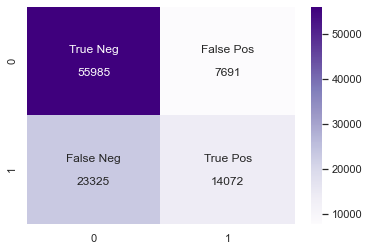

In [31]:
cf_matrix = confusion_matrix(Y_test , y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')
plt.grid(b=None)

plt.show()

<H1> SVC (support vector classification)</H1> 

In [ ]:
model = SVC()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(Y_test , y_pred))
print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

In [ ]:
cf_matrix = confusion_matrix(Y_test , y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Red')
plt.grid(b=None)

plt.show()

# Decision Tree Classifier

In [32]:
model = DecisionTreeClassifier()
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(Y_test , y_pred))
print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

Accuracy :  0.6987128115322588
Confusion Matrix : 
 [[47225 16451]
 [14001 23396]]
f-measure :  0.6057687328465641


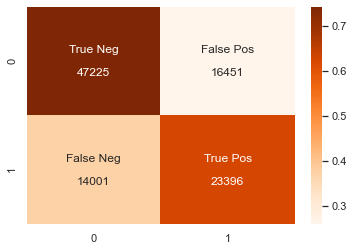

In [33]:

cf_matrix = confusion_matrix(Y_test , y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

cf_matrixn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(cf_matrixn, annot=labels, fmt='', cmap='Oranges')

plt.grid(b=None)

plt.show()

<AxesSubplot:>

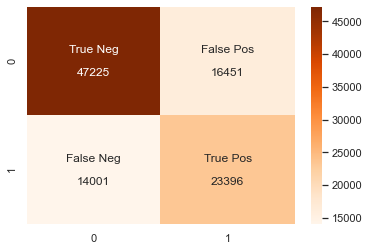

In [34]:
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')

# Random Forest Classifier

In [35]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train,Y_train)
y_pred = model.predict(X_test)
print("Accuracy : " ,accuracy_score(Y_test , y_pred))
model_accuracy.append(accuracy_score(Y_test , y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(Y_test , y_pred))
print("f-measure : " ,f1_score(Y_test , y_pred))
model_fm.append(f1_score(Y_test , y_pred))

Accuracy :  0.7965035172598023
Confusion Matrix : 
 [[58931  4745]
 [15823 21574]]
f-measure :  0.6771925419047021


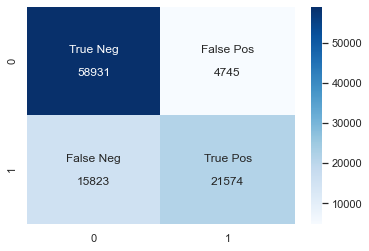

In [36]:
cf_matrix = confusion_matrix(Y_test , y_pred)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.grid(b=None)

plt.show()

# Model Comparison

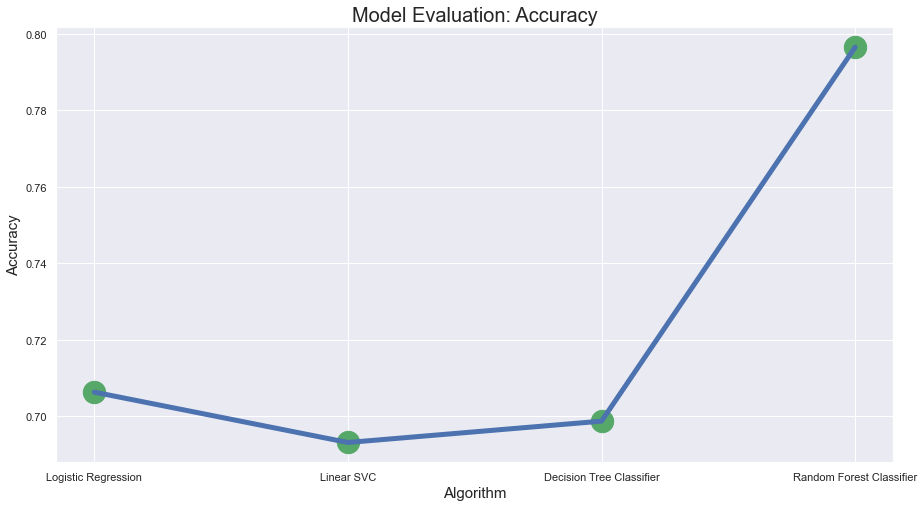

In [37]:
model_name = ["Logistic Regression", "Linear SVC", "Decision Tree Classifier", "Random Forest Classifier"]
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(model_accuracy)), model_accuracy, linewidth = 5)
plt.xticks(np.arange(len(model_name)), model_name)
plt.title("Model Evaluation: Accuracy",size = 20)
plt.ylabel("Accuracy",size = 15)
plt.xlabel("Algorithm",size = 15)
plt.scatter(np.arange(len(model_accuracy)), model_accuracy,c = "g",s = 500)
plt.show()

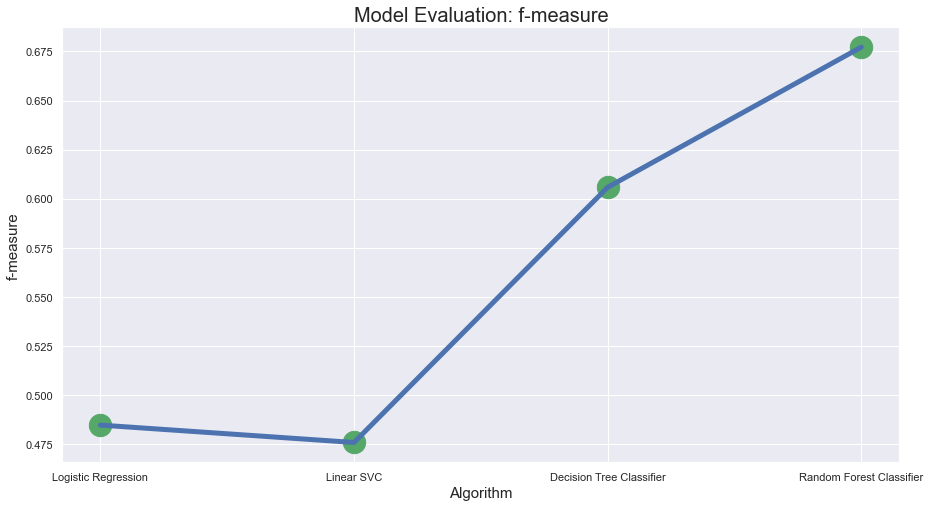

In [38]:
model_name = ["Logistic Regression", "Linear SVC", "Decision Tree Classifier", "Random Forest Classifier"]
plt.figure(figsize = (15,8))
plt.plot(np.arange(len(model_fm)), model_fm, linewidth = 5)
plt.xticks(np.arange(len(model_name)), model_name)
plt.title("Model Evaluation: f-measure",size = 20)
plt.ylabel("f-measure",size = 15)
plt.xlabel("Algorithm",size = 15)
plt.scatter(np.arange(len(model_fm)), model_fm,c = "g",s = 500)
plt.show()